In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.model_selection import KFold

In [4]:
#Data reading
df = pd.read_csv("worldcoin-org_2023-07-24_2024-09-20.csv")
df

,Start,End,Open,High,Low,Close,Volume,Market Cap
0,2024-09-19,2024-09-20,200.230327,212.106582,198.374500,205.695640,7.132699e+10,9.150957e+10
1,2024-09-18,2024-09-19,188.305880,199.477624,184.037433,199.477624,4.713701e+10,8.460954e+10
2,2024-09-17,2024-09-18,182.005667,189.902632,179.929701,187.779677,4.191690e+10,8.099784e+10
3,2024-09-16,2024-09-17,189.331293,189.331293,178.401239,182.249198,5.452660e+10,7.791811e+10
4,2024-09-15,2024-09-16,194.384816,201.122540,188.887849,189.929580,4.570792e+10,8.292824e+10
...,...,...,...,...,...,...,...,...
419,2023-07-28,2023-07-29,266.303801,286.533403,264.554328,285.644185,6.007178e+10,2.919856e+10
420,2023-07-27,2023-07-28,287.676920,295.834139,268.693036,269.989743,9.477407e+10,2.970630e+10
421,2023-07-26,2023-07-27,293.852710,321.444574,282.445740,289.173453,1.894057e+11,3.163373e+10
422,2023-07-25,2023-07-26,278.619394,309.644293,245.956788,293.075495,1.737368e+11,2.890207e+10


In [5]:
#convert Start and End columns to datetime
df["Start"] = pd.to_datetime(df["Start"])
df["End"] = pd.to_datetime(df["End"])

In [6]:
#Features and target variable
X = df[["Open", "High", "Low", "Volume", "Market Cap"]]
y = df["Close"]

In [7]:
#Splitting data to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
#Scale the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# Increase Model Complexity
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-4)
model.compile(optimizer=optimizer, loss='mse')

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', verbose=1)

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=200, batch_size=32, 
                    validation_split=0.2, verbose=1, 
                    callbacks=[lr_scheduler, early_stopping, checkpoint])

Epoch 1/200
1/9 [==>...........................] - ETA: 5s - loss: 219277.2500
Epoch 1: val_loss improved from inf to 279211.28125, saving model to best_model.h5
9/9 [==============================] - 1s 48ms/step - loss: 260274.5312 - val_loss: 279211.2812 - lr: 0.0010
Epoch 2/200
1/9 [==>...........................] - ETA: 0s - loss: 263345.1875
Epoch 2: val_loss improved from 279211.28125 to 278417.75000, saving model to best_model.h5
9/9 [==============================] - 0s 12ms/step - loss: 259868.4844 - val_loss: 278417.7500 - lr: 0.0010
Epoch 3/200
1/9 [==>...........................] - ETA: 0s - loss: 324346.5312
Epoch 3: val_loss improved from 278417.75000 to 276276.06250, saving model to best_model.h5
9/9 [==============================] - 0s 12ms/step - loss: 258771.6875 - val_loss: 276276.0625 - lr: 0.0010
Epoch 4/200
1/9 [==>...........................] - ETA: 0s - loss: 256867.2656
Epoch 4: val_loss improved from 276276.06250 to 270268.68750, saving model to best_model.h

In [10]:
# Ensure X_train_scaled and y_train are NumPy arrays
X_train_scaled = np.array(X_train_scaled)
y_train = np.array(y_train)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
val_scores = []

for train_index, val_index in kfold.split(X_train_scaled):
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    
    optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-4)
    model.compile(optimizer=optimizer, loss='mse')
    
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6, verbose=1)
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, verbose=1)
    checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', verbose=1)
    
    history = model.fit(X_train_fold, y_train_fold, epochs=200, batch_size=32, 
                        validation_data=(X_val_fold, y_val_fold), verbose=1, 
                        callbacks=[lr_scheduler, early_stopping, checkpoint])
    
    val_loss = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    val_scores.append(val_loss)

print(f'Validation MSE scores for each fold: {val_scores}')
print(f'Mean Validation MSE: {np.mean(val_scores)}')

Epoch 1/200
1/9 [==>...........................] - ETA: 5s - loss: 156744.3750
Epoch 1: val_loss improved from inf to 305506.37500, saving model to best_model.h5
9/9 [==============================] - 1s 41ms/step - loss: 253461.8750 - val_loss: 305506.3750 - lr: 0.0010
Epoch 2/200
1/9 [==>...........................] - ETA: 0s - loss: 191437.1875
Epoch 2: val_loss improved from 305506.37500 to 303736.65625, saving model to best_model.h5
9/9 [==============================] - 0s 12ms/step - loss: 252648.1250 - val_loss: 303736.6562 - lr: 0.0010
Epoch 3/200
1/9 [==>...........................] - ETA: 0s - loss: 203830.9219
Epoch 3: val_loss improved from 303736.65625 to 298443.34375, saving model to best_model.h5
9/9 [==============================] - 0s 12ms/step - loss: 250200.7031 - val_loss: 298443.3438 - lr: 0.0010
Epoch 4/200
1/9 [==>...........................] - ETA: 0s - loss: 191548.0938
Epoch 4: val_loss improved from 298443.34375 to 283841.93750, saving model to best_model.h

3/3 [==============================] - 0s 3ms/step


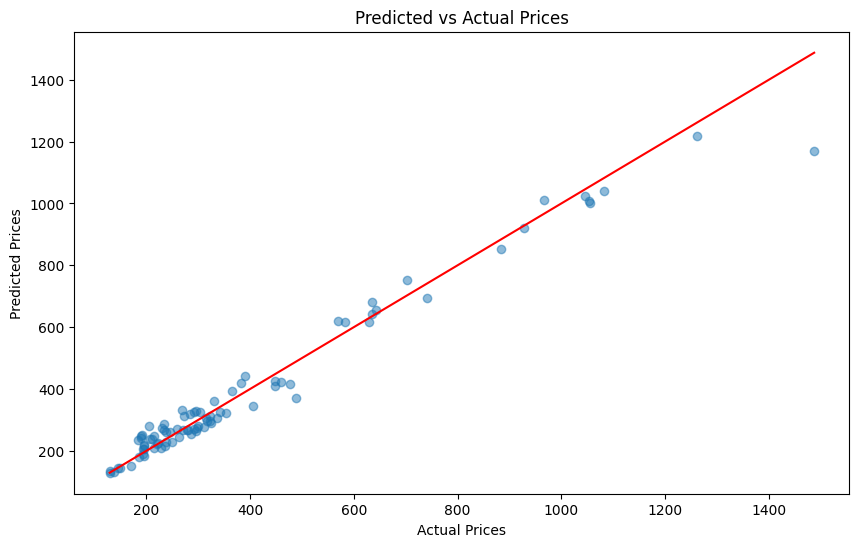

In [11]:
# Load the best weights
model.load_weights('best_model.h5')

# Assuming you have X_test_scaled and y_test as your test dataset
# Replace these with your actual test datasets
X_test_scaled = np.array(X_test_scaled)
y_test = np.array(y_test)

# Predict the prices on the test set
y_pred = model.predict(X_test_scaled)

# Plot Predicted vs Actual Prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Diagonal line
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs Actual Prices')
plt.show()

In [12]:
# Save the model
model.save('trained_model.h5')